In [ ]:
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler


import resnet
from resnet import resnet56


NUM_GPUS = 1
BS_PER_GPU = 128
NUM_EPOCHS = 4

HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
NUM_CLASSES = 10
NUM_TRAIN_SAMPLES = 50000

BASE_LEARNING_RATE = 0.1

def normalize(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y

def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, HEIGHT + 8, WIDTH + 8)
    x = tf.image.random_crop(x, [HEIGHT, WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y





## Preapr

In [150]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('sparse_categorical_accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_sparse_categorical_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
    def save_plot(self):

        N = np.arange(0, len(self.losses))

        # Plot train loss, train acc, val loss and val acc against epochs passed
        plt.figure()
        plt.plot(N, self.losses, label = "train_loss")
        plt.plot(N, self.acc, label = "train_acc")
        plt.plot(N, self.val_losses, label = "val_loss")
        plt.plot(N, self.val_acc, label = "val_acc")
        plt.title("Training Loss and Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.savefig("training_plot.png")

plot_losses = TrainingPlot()

In [151]:
(x,y), (x_test, y_test) = keras.datasets.cifar10.load_data()

train_dataset = tf.data.Dataset.from_tensor_slices((x,y))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

tf.random.set_seed(22)
train_dataset = train_dataset.map(augmentation).map(normalize).shuffle(NUM_TRAIN_SAMPLES).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)
test_dataset = test_dataset.map(normalize).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)


input_shape = (HEIGHT, WIDTH, NUM_CHANNELS)
img_input = tf.keras.layers.Input(shape=input_shape)
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)


model = resnet56(img_input=img_input, classes=NUM_CLASSES)
model.compile(
          optimizer=opt,
          loss='sparse_categorical_crossentropy',
          metrics=['sparse_categorical_accuracy'])
  

model.fit(train_dataset,
          epochs=NUM_EPOCHS,
          validation_data=test_dataset,
          validation_freq=1,
          callbacks=[plot_losses])

model.evaluate(test_dataset)

model.save('model.h5')

new_model = keras.models.load_model('model.h5')
 
new_model.evaluate(test_dataset)

Epoch 1/4
390/390 [==============================] - 80s 206ms/step - loss: 4.1597 - sparse_categorical_accuracy: 0.2304 - val_loss: 6.1812 - val_sparse_categorical_accuracy: 0.1140
Epoch 2/4
390/390 [==============================] - 79s 202ms/step - loss: 3.2737 - sparse_categorical_accuracy: 0.3733 - val_loss: 3.5398 - val_sparse_categorical_accuracy: 0.2804
Epoch 3/4
390/390 [==============================] - 79s 203ms/step - loss: 2.7146 - sparse_categorical_accuracy: 0.4439 - val_loss: 3.1746 - val_sparse_categorical_accuracy: 0.2952
Epoch 4/4
78/78 [==============================] - 4s 54ms/step - loss: 3.2320 - sparse_categorical_accuracy: 0.3217


[3.232027530670166, 0.32171472907066345]

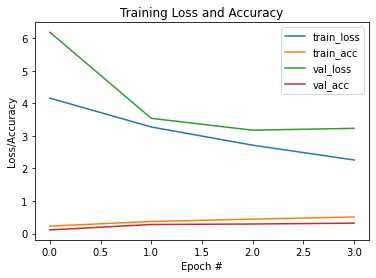

In [152]:
plot_losses.save_plot()

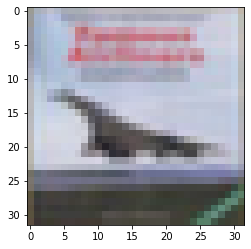

In [102]:
plt.imshow(x_test[3])

In [103]:
classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

In [108]:
index = 1


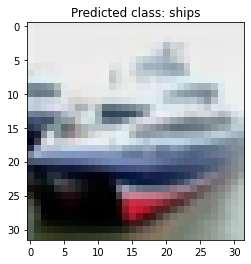

In [109]:
pred_class = np.argmax(new_model.predict(np.array([x_test[index]])))
plt.title("Predicted class: " + classes[pred_class])
plt.imshow(x_test[index])

In [112]:
log_dir="logs/fit/20201001-151512"

In [113]:
log_dir

'logs/fit/20201001-151512'

In [121]:
from tensorflow.python.summary.summary_iterator import summary_iterator